## 相机内参标定 
通过拍摄多张棋盘格照片得到相机内参。

In [13]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

path = 'D:\\labAAA\\printingLight\\process\\camera_set\\chessboard'
list_path = os.listdir(path)
# print(list_path)


w, h = 10, 7
square_size = 15
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
# 准备棋盘格的世界坐标点
objp = np.zeros((w * h, 3), np.float32)
objp[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)
objp *= square_size


grays = []
pImgs = []
objpoints = []  # 世界坐标点
imgpoints = []  # 图像像素点


# 遍历图像并检测棋盘角点
for file in list_path:
    file_name = os.path.join(path, file)
    img = cv2.imread(file_name)
    scale = 0.5  # 50%缩小
    img_resize = cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))
    

    gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    # gray_resize = cv2.resize(gray, (int(gray.shape[1] * scale), int(gray.shape[0] * scale)))
    print('image pixel', gray.shape[::-1])
    grays.append(gray)

    ret, corners = cv2.findChessboardCorners(gray, (w, h), None)
    print(f"Chessboard found in {file}: {ret}")
    
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        


        # 可视化检测到的角点（用 matplotlib 替代 OpenCV）
        # img_with_corners = img_resize.copy()
        # cv2.drawChessboardCorners(img_with_corners, (w, h), corners2, ret)
        #使用 matplotlib 显示
        # plt.figure(figsize=(8, 6))
        # plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))  # 转换为 RGB 格式
        # plt.scatter(corners2[:, 0, 0], corners2[:, 0, 1], marker='o', c='red', s=10, label="Detected Corners")  # `s`控制点大小
        # plt.title(f"Detected Corners: {file}")
        # plt.rcParams['lines.linewidth'] = 2  # 设置线条宽度
        # plt.axis("off")  # 隐藏坐标轴
        # plt.show()


# 相机标定
print("\nStarting camera calibration...")
# ret, camera_matrix, distortion_coeffs, rvecs, tvecs = cv2.calibrateCamera(
#     objpoints, imgpoints, grays[0].shape[::-1], None, None
# )
ret, camera_matrix, distortion_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, grays[0].shape[::-1], None, None,flags=cv2.CALIB_FIX_K3 | cv2.CALIB_FIX_K4 | cv2.CALIB_FIX_K5
)

# 打印结果
print("相机矩阵 (Camera Matrix):\n", camera_matrix)
print("\n畸变系数 (Distortion Coefficients):\n", distortion_coeffs)

# 计算重投影误差
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], camera_matrix, distortion_coeffs)
    error = cv2.norm(imgpoints[i].squeeze(), imgpoints2.squeeze(), cv2.NORM_L2) / len(imgpoints2)
    mean_error += error

print("\n总平均误差 (Mean Reprojection Error):", mean_error / len(objpoints))

# 保存标定结果
np.savez("calibration_result.npz", camera_matrix=camera_matrix, distortion_coeffs=distortion_coeffs, rvecs=rvecs, tvecs=tvecs)

# for file in list_path:
#     file_name = os.path.join(path, file)
#     img = cv2.imread(file_name)
#     scale = 0.5  # 50%缩小
#     img_resize = cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))
#     undistorted_img = cv2.undistort(img_resize, camera_matrix, distortion_coeffs)
#     plt.figure(figsize=(8, 6))
#     plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))  # 转换为 RGB 格式
#     plt.title(f"Detected Corners: {file}")
#     plt.axis("off")  # 隐藏坐标轴
#     plt.show()


image pixel (2736, 1824)
Chessboard found in IMG_6519.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6520.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6521.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6523.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6525.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6526.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6528.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6529.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6530.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6531.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6532.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6534.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6535.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6541.JPG: True
image pixel (2736, 1824)
Chessboard found in IMG_6542.JPG: True
image pixel (2736, 1824)
Chessboard foun

## 相机外参计算
在实验前拍摄一张完整的棋盘格pattern，检测格点的像素坐标，并与其在样品坐标系的坐标比对，算出相机外参。计算出的矩阵似乎是从相机位置移动到原点的变换，而非相机在坐标系中的位置，所以正负是相反的。
（目前误差有点大）

### 1 读取棋盘格角点

In [14]:
import cv2
import numpy as np

# 读取图像
image_path = 'D:\\labAAA\\printingLight\\process\\camera_set\\test250308\\camera_calib\\IMG_6563.png'
img = cv2.imread(image_path)
scale_factor = 2  # 你的缩放比例
new_camera_matrix = camera_matrix.copy()
new_camera_matrix[0, 0] *= scale_factor  # fx
new_camera_matrix[1, 1] *= scale_factor  # fy
new_camera_matrix[0, 2] *= scale_factor  # cx
new_camera_matrix[1, 2] *= scale_factor  # cy
print(new_camera_matrix)


[[1.00164231e+04 0.00000000e+00 2.77132344e+03]
 [0.00000000e+00 1.00158486e+04 1.69584526e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Corners (Pixel Coordinates):
第0个点 (2107.31, 871.84)
第1个点 (2687.61, 939.41)
第2个点 (3266.61, 1005.92)
第3个点 (3845.40, 1071.56)
第4个点 (2048.39, 1446.18)
第5个点 (2621.70, 1511.59)
第6个点 (3195.71, 1577.70)
第7个点 (3767.61, 1642.32)
第8个点 (1990.45, 2007.59)
第9个点 (2559.13, 2072.23)
第10个点 (3125.39, 2136.73)
第11个点 (3692.05, 2200.67)
第12个点 (1933.38, 2557.32)
第13个点 (2495.93, 2620.36)
第14个点 (3057.24, 2684.07)
第15个点 (3618.61, 2747.67)


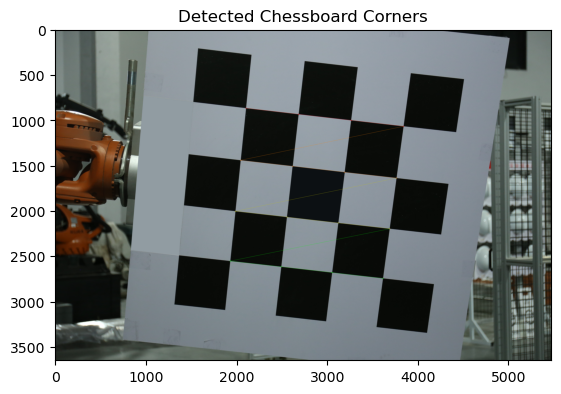

In [15]:
import cv2
import numpy as np

# 读取图像
# image_path = 'D:\\labAAA\\printingLight\\process\\camera_set\\test250305\\camera_calib\\IMG_6291.png'
# img = cv2.imread(image_path)

# scale_factor = 2  # 你的缩放比例
# new_camera_matrix = camera_matrix.copy()
# new_camera_matrix[0, 0] *= scale_factor  # fx
# new_camera_matrix[1, 1] *= scale_factor  # fy
# new_camera_matrix[0, 2] *= scale_factor  # cx
# new_camera_matrix[1, 2] *= scale_factor  # cy
# print(new_camera_matrix)
# undistorted_img = cv2.undistort(img, new_camera_matrix, distortion_coeffs)
# 转换为灰度图像
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 棋盘格尺寸（内部角点数，即横向和纵向的角点数 - 1）
w, h = 4, 4  

# 查找棋盘格角点
ret, corners = cv2.findChessboardCorners(gray, (w, h), None)

# 如果找到了角点
if ret:
    # 通过角点亚像素精确化，提高角点位置精度
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
    corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    # 打印每个交点的像素坐标
    corner_list = corners2.tolist()
    print("Corners (Pixel Coordinates):")
    for corner in corner_list:
        print(f'第{corner_list.index(corner)}个点',f"({corner[0][0]:.2f}, {corner[0][1]:.2f})")

    # 可视化角点
    img_with_corners = cv2.drawChessboardCorners(img, (w, h), corners2, ret)
    cv2.imwrite('D:\\labAAA\\printingLight\\process\\camera_set\\test250308\\camera_calib\\corners_default.png', img_with_corners)

    # 使用 matplotlib 显示图像
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
    plt.title("Detected Chessboard Corners")
    plt.show()

else:
    print("Chessboard corners not found.")

### 2 计算角点在样品坐标系下的坐标

### 试用eye to hand计算

In [31]:
from scipy.spatial.transform import Rotation as R
import cv2
import numpy as np

#从XYZABC输出变换矩阵
def kuka_to_transformation(x, y, z, a, b, c):
    """将 KUKA 的点位信息转换为 4x4 变换矩阵"""
    # 平移向量
    t = np.array([x, y, z])
    
    # 计算旋转矩阵（ZYX顺序）
    rotation = R.from_euler('ZYX', [a, b, c], degrees=True)  # KUKA的ABC通常以度为单位
    R_matrix = rotation.as_matrix()
    # print(R_matrix)
    
    # 构造4x4变换矩阵
    T = np.eye(4)
    T[:3, :3] = R_matrix
    T[:3, 3] = t
    # print('T', T)
    return T

#从变换矩阵求旋转之后的棋盘格点在样品坐标系里的坐标
def transform_points(origin_points, T_1,T_2):

    # 将3D点转换为齐次坐标
    origin_points_h = np.hstack([origin_points, np.ones((origin_points.shape[0], 1))])

    # 使用矩阵乘法进行坐标变换
    #去掉齐次坐标中的最后一列，转换回普通的3D坐标
    object_points_base_inv = np.dot(T_2, origin_points_h.T)
    object_points_o1 = np.dot(np.linalg.inv(T_1), object_points_base_inv).T
    return object_points_o1[:, :3]



T_o1 = kuka_to_transformation(-170, -1800, 1500, 58, 0, 90)  # 姿态1的变换矩阵
T_o2 = kuka_to_transformation(1181.42, -2733.69, 1500, 57.72, -7.11, 78.67)  # 姿态2的变换矩阵，这里用的是第一个位置
# 已知的3D点坐标，以棋盘格中心为原点
# 后续可以把所有格点都用上计算
grid_size = 90
grid_extend = [3,1,-1,-3]
grid_extend_j = [-3,-1,1,3]
# points = np.array([(i*grid_size,j*grid_size,0) for i in grid_extend_j for j in grid_extend ])
points = np.array([(i*grid_size,j*grid_size,0) for j in grid_extend for i in grid_extend ])

# points = np.array([
#     [270, 270, 0],
#     [270, -270, 0],
#     [-270, -270, 0],
#     [-270, 270, 0]
# ], dtype=np.float32)

print(points)
#由于样品坐标系原点（也就是TCP）不在表面的中心，所以要计算格点在样品坐标系内的坐标
translation_vec = np.array([0.304,-0.944,-50.498])
# translation_vec = np.array([0.304,0,-50.498])
origin_points = points + translation_vec
# print(origin_points)
# object_points = transform_points(origin_points,T_o1,T_o2)
# object_points = transform_points(points,T_o1,T_o2) + np.array([21.1771,-17.55,-6.745])
object_points = transform_points(origin_points,T_o1,T_o2) 
print('Objects Points in O2:\n', object_points)

# 已知的像素坐标
# #后面直接用上一步得出的corners2
# print(corners2)

image_points = corners2
# image_points = corners2
print(image_points)
# image_points = np.array([
#     [1414.22, 831.41],
#     [1660.36, 2741.38],
#     [2943.26, 2564.70],
#     [2680.50,679.88]
# ], dtype=np.float32)

# 相机内参矩阵，后续也直接用上一步得出的
# camera_matrix =  np.array( [[1.07480575e+04, 0.00000000e+00, 2.50017782e+03,],
#  [0.00000000e+00, 1.09558245e+04, 2.90769245e+02],
#  [0.00000000e+0, 0.00000000e+00, 1.00000000e+00]],dtype=np.float32)


# distortion_coeffs = np.array([[0,  0, 0, 0,
#   0]],dtype=np.float32)

# 求解相机位置和姿态

_, rvec, tvec, inliners = cv2.solvePnPRansac(object_points, image_points.squeeze(), new_camera_matrix, distortion_coeffs)

if not _:
    print("PnP 求解失败")

# 输出旋转矩阵
rotation_matrix, _ = cv2.Rodrigues(rvec)

print("Rotation Matrix:\n", rotation_matrix)
print("Translation Vector:\n", tvec)

# 使用相机内参矩阵、畸变系数、rvec 和 tvec 重投影物体点
imgpoints2, _ = cv2.projectPoints(object_points, rvec, tvec, new_camera_matrix, distortion_coeffs)

# 如果 image_points 是 n x 1 x 2 的格式，调整为 n x 2 的格式
image_points = np.array(image_points, dtype=np.float32).reshape(-1, 2)

# 如果 imgpoints2 是 n x 1 x 2 的格式，调整为 n x 2 的格式
imgpoints2 = np.array(imgpoints2, dtype=np.float32).reshape(-1, 2)
# 计算重投影误差
error = cv2.norm(image_points.squeeze(), imgpoints2.squeeze(), cv2.NORM_L2) / len(imgpoints2)
print("重投影误差 (Mean Reprojection Error):", error)

[[ 270  270    0]
 [  90  270    0]
 [ -90  270    0]
 [-270  270    0]
 [ 270   90    0]
 [  90   90    0]
 [ -90   90    0]
 [-270   90    0]
 [ 270  -90    0]
 [  90  -90    0]
 [ -90  -90    0]
 [-270  -90    0]
 [ 270 -270    0]
 [  90 -270    0]
 [ -90 -270    0]
 [-270 -270    0]]
Objects Points in O2:
 [[ 161.62700511  285.39625108 1539.63540099]
 [ -16.98672509  263.11681058 1538.76252269]
 [-195.60045528  240.83737008 1537.88964439]
 [-374.21418548  218.55792957 1537.01676609]
 [ 183.29918722  110.26126702 1575.10445624]
 [   4.68545702   87.98182652 1574.23157794]
 [-173.92827317   65.70238602 1573.35869964]
 [-352.54200337   43.42294551 1572.48582134]
 [ 204.97136933  -64.87371704 1610.5735115 ]
 [  26.35763913  -87.15315754 1609.7006332 ]
 [-152.25609106 -109.43259805 1608.8277549 ]
 [-330.86982126 -131.71203855 1607.9548766 ]
 [ 226.64355144 -240.0087011  1646.04256675]
 [  48.02982125 -262.2881416  1645.16968845]
 [-130.58390895 -284.56758211 1644.29681015]
 [-309.197639

### 3 计算机器人路径中的所有变换
暂时没用到

In [ ]:
import numpy as np
import itertools
from scipy.spatial.transform import Rotation as R

#欧拉角组合
degree = np.array([-20,-10,0,10,20])
euler_combos = list(itertools.product(degree,repeat = 3))
print(euler_combos)
#旋转矩阵
rotations = [R.from_euler('zyx', angles,degrees=True) for angles in euler_combos]
#网格点
motion_grid_size = 50
motion_grid_extend = [-2,-1,0,1,2]
motion_grid = np.array([(i*motion_grid_size,j*motion_grid_size,0) for i in motion_grid_extend for j in motion_grid_extend])
# print(motion_grid)
#计算相机相对于样品的坐标
points = []
#相机坐标，并构建齐次坐标
# camera = np.array([ -157.26308306, -234.46892435, -1723.93744597])
camera = -tvec
camera_h = np.append(camera,1)

for rotation in rotations:
    for g in motion_grid:
        T = np.eye(4)
        T[:3, :3] = rotation.as_matrix()
        T[:3, 3] = g
        point = np.dot(np.linalg.inv(T),camera_h)
        points.append(point)

# print(points)  

[(-20, -20, -20), (-20, -20, -10), (-20, -20, 0), (-20, -20, 10), (-20, -20, 20), (-20, -10, -20), (-20, -10, -10), (-20, -10, 0), (-20, -10, 10), (-20, -10, 20), (-20, 0, -20), (-20, 0, -10), (-20, 0, 0), (-20, 0, 10), (-20, 0, 20), (-20, 10, -20), (-20, 10, -10), (-20, 10, 0), (-20, 10, 10), (-20, 10, 20), (-20, 20, -20), (-20, 20, -10), (-20, 20, 0), (-20, 20, 10), (-20, 20, 20), (-10, -20, -20), (-10, -20, -10), (-10, -20, 0), (-10, -20, 10), (-10, -20, 20), (-10, -10, -20), (-10, -10, -10), (-10, -10, 0), (-10, -10, 10), (-10, -10, 20), (-10, 0, -20), (-10, 0, -10), (-10, 0, 0), (-10, 0, 10), (-10, 0, 20), (-10, 10, -20), (-10, 10, -10), (-10, 10, 0), (-10, 10, 10), (-10, 10, 20), (-10, 20, -20), (-10, 20, -10), (-10, 20, 0), (-10, 20, 10), (-10, 20, 20), (0, -20, -20), (0, -20, -10), (0, -20, 0), (0, -20, 10), (0, -20, 20), (0, -10, -20), (0, -10, -10), (0, -10, 0), (0, -10, 10), (0, -10, 20), (0, 0, -20), (0, 0, -10), (0, 0, 0), (0, 0, 10), (0, 0, 20), (0, 10, -20), (0, 10, -10)

### 测试外参结果的准确度
使用外参标定时的另一张照片

In [30]:
corner = np.array([
    [90, 90, 0],
    [90, -90, 0],
    [-90, -90, 0],
    [-90, 90, 0]
], dtype=np.float32) + translation_vec#由于样品坐标系原点（也就是TCP）不在表面的中心，所以要计算格点在样品坐标系内的坐标
# corner = np.array([ 
#     [90, 90, 0],
#     [90, -90, 0],
#     [-90, -90, 0],
#     [-90, 90, 0]
# ], dtype=np.float32) 
#计算旋转以后的样品角点，这里只取了第一个做实验
T = kuka_to_transformation(-222.92, -1884.805, 1400, 32.616, 12.209, 70.802)#第一个路径点
#取标定外参时拍的另一张来实验
# T_test = kuka_to_transformation(1181.42, -2733.69, 1500, 57.72, -7.12, 78.67)#第一个标定点
# T = kuka_to_transformation(1181.42, -2733.69, 1500, 57.85, 5.18, 70.95)#第二个标定点
# T_test = kuka_to_transformation(1181.42, -2733.69, 1500, 63.45, -7.25, 82.23)
# corner_points = transform_points(corner,T_o1,T_test) + np.array([21.1771,-17.55,-6.745])
corner_points = transform_points(corner,T_o1,T)

print('角点坐标',corner_points)
#计算投影在成像平面上的像素点
project_corner_points2, _ = cv2.projectPoints(corner_points, rvec, tvec, new_camera_matrix, distortion_coeffs)
print(project_corner_points2)

#绘制四边形
def draw_quadrilateral(image, points, output_path):
    """
    在图像上绘制四边形并保存结果

    参数:
    image: 输入图像
    points: 四个顶点坐标的列表 [(x1,y1), (x2,y2), (x3,y3), (x4,y4)]
    output_path: 输出图像的保存路径
    """
    # 将输入点转换为numpy数组
    pts = np.array(points, dtype=np.int32)

    # 在图像上绘制四边形
    cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=5)

    # 保存结果
    cv2.imwrite(output_path, image)

# 使用示例:
if __name__ == "__main__":
    # 读取图像
    # image = cv2.imread('D:\\labAAA\\printingLight\\process\\camera_set\\test250308\\camera_calib\\IMG_6564.JPG')
    image = cv2.imread('D:\\labAAA\\printingLight\\process\\camera_set\\test250308\\images\\IMG_6567.JPG')
    


    points = project_corner_points2.tolist()
  
    # points = [corner_list[5], corner_list[6],corner_list[9],corner_list[10]]
    # 输出图像的保存路径
    # output_path = 'D:\\labAAA\\printingLight\\process\\camera_set\\test250308\\camera_calib\\draw_IMG_6564.JPG'
    output_path = 'D:\\labAAA\\printingLight\\process\\camera_set\\test250308\\images\\draw_IMG_6567.JPG'
    
    # 在图像上绘制四边形并保存
    draw_quadrilateral(image, project_corner_points2, output_path)

角点坐标 [[  25.97551907  -52.25466143  -25.72596674]
 [ -31.87669687 -218.39976157   12.33880455]
 [-190.82053337 -180.33366289  -63.07889212]
 [-132.96831744  -14.18856276 -101.1436634 ]]
[[[2583.79593884 2030.91101969]]

 [[2965.52936655 3090.08061773]]

 [[4054.85833421 2880.04468028]]

 [[3680.25584038 1762.74470691]]]
